# Exploratory data analysis HUPA-UCM Diabetes 
<br>**Participantes**<br>
- Morales Martinez Arturo 
- Moreno Santa Maria Luis Daniel

<br>**Dataset:**<br>
- Origen : Universidad de Madrid
<br>**Sensores:**<br>
- Freestle libre 2 for the Continuous Glucose Monitoring
- Fitbit Ionic smartwatches for the other variables (steps, calories, heartrate \& sleepdata)
<br>**Variables:**<br>
- time: time of data recording (yyyy-MM-dd’T’HH:mm:ss format)
- glucose: blood glucose value (mg/dL)
- calories: calories burned in the time Interval
- heart_rate: heart frequency
- steps: steps taken in the time interval
- basal_rate: basal insulin infusions in the time interval
- bolus_volume_delivered: insulin bolus injections in the time interval
- carb_input: servings of carbohydrates ingested in the time interval (1 serving = 10 g)

## Libraries & Configuration

In [408]:
# Miscellaneous Funcionality
import os, glob
import re
import datetime

# ETL
import numpy as np
import pandas as pd


# Visualization
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# Math
import math
import scipy.stats as stats
import statsmodels.tsa as tsa

In [409]:
# plot customization hyperparameters
sns.set_theme()
size = 2
a = .5 # alpha = transparencia
width = 6.3 * 2 # 21cm - 5cm = 16 cm = 6.3 inches
flierprops = dict(marker = "+", color = "r")

In [410]:
data_dir = 'HUPA-UCM Diabetes Dataset/Preprocessed'

## Exploratory Data Analysis

### Preprocessed data

In [411]:
# Append all the patients onto a single dataframe
people = []
path = "HUPA-UCM Diabetes Dataset/Preprocessed/"
#id = 0 
for filename in glob.glob(os.path.join(path, '*.csv')):
    df = pd.read_csv(filename, sep = ";")
    df["time"] = df["time"].apply(lambda x: np.datetime64(x))
    #df["patient_id"] = [id for i in range(len(df))]
    # df = df.set_index(['patient_id', 'time'])
    people.append(df)
    id += 1

In [412]:
# t_(i) - t_(i-1)
def diff(ts):
    new_ts = []
    for i in range(1,len(ts)):
        value = ts[i] - ts[i - 1]
        new_ts.append(value)
    return new_ts

In [413]:
# differenciate the dataframes

diff1_people = []
for person in people:
    person = person.drop(columns = ["time"])
    diff1_columns = []
    cols = person.columns
    for column in cols:
        diff1_column = diff(person[column])
        diff1_columns.append(diff1_column)
    diff1_person = pd.DataFrame(data  = {
        'glucose' : diff1_columns[0],
        'calories' : diff1_columns[1],
        'heart_rate' : diff1_columns[2],
        'steps' : diff1_columns[3],
        'basal_rate' : diff1_columns[4],
        'bolus_volume_delivered' : diff1_columns[5],
        'carb_input' : diff1_columns[6]
    })
    diff1_people.append(diff1_person)

diff2_people = []
for diff1_person in diff1_people:
    diff2_columns = []
    for column in cols:
        diff2_column = diff(diff1_person[column])
        diff2_columns.append(diff2_column)
    diff2_person = pd.DataFrame(data  = {
        'glucose' : diff2_columns[0],
        'calories' : diff2_columns[1],
        'heart_rate' : diff2_columns[2],
        'steps' : diff2_columns[3],
        'basal_rate' : diff2_columns[4],
        'bolus_volume_delivered' : diff2_columns[5],
        'carb_input' : diff2_columns[6]
    })
    diff2_people.append(diff2_person)

In [414]:
df = pd.concat(people)
df_d1 = pd.concat(diff1_people)
df_d2 = pd.concat(diff2_people)

#### Rows per pacient

In [415]:
# Find patient's number
def find_number_string(string):
    numbers = re.findall(r'\d+', string)
    return numbers

In [416]:
# The following cell is intended to get a dictionary where each key is the patient's id amd the value the number of rows 
patients = {int(find_number_string(os.path.join(data_dir, filename))[0]) : pd.read_csv(os.path.join(data_dir, filename), sep=';').shape[0]
                   for filename in os.listdir(data_dir)}

# Just to sort by the amount of rows
patients = dict(sorted(patients.items(), key=lambda item: item[1]))

In [417]:
# Now, just tabulate days, months and year per patient
table = [] 
for key, value in patients.items():
    days = value / 288
    months = days / 30
    years = months / 12
    table.append([key, value, days, months, years])
print(tabulate(table, headers=["Patient", "Rows", "Days", "Months", "Years"], tablefmt="grid"))

+-----------+--------+-----------+-----------+-----------+
|   Patient |   Rows |      Days |    Months |     Years |
+===========+========+===========+===========+===========+
|         6 |   2290 |   7.95139 |  0.265046 | 0.0220872 |
+-----------+--------+-----------+-----------+-----------+
|        18 |   2343 |   8.13542 |  0.271181 | 0.0225984 |
+-----------+--------+-----------+-----------+-----------+
|        17 |   2862 |   9.9375  |  0.33125  | 0.0276042 |
+-----------+--------+-----------+-----------+-----------+
|        21 |   2902 |  10.0764  |  0.33588  | 0.02799   |
+-----------+--------+-----------+-----------+-----------+
|         9 |   2976 |  10.3333  |  0.344444 | 0.0287037 |
+-----------+--------+-----------+-----------+-----------+
|         2 |   3181 |  11.0451  |  0.368171 | 0.0306809 |
+-----------+--------+-----------+-----------+-----------+
|         4 |   3184 |  11.0556  |  0.368519 | 0.0307099 |
+-----------+--------+-----------+-----------+----------

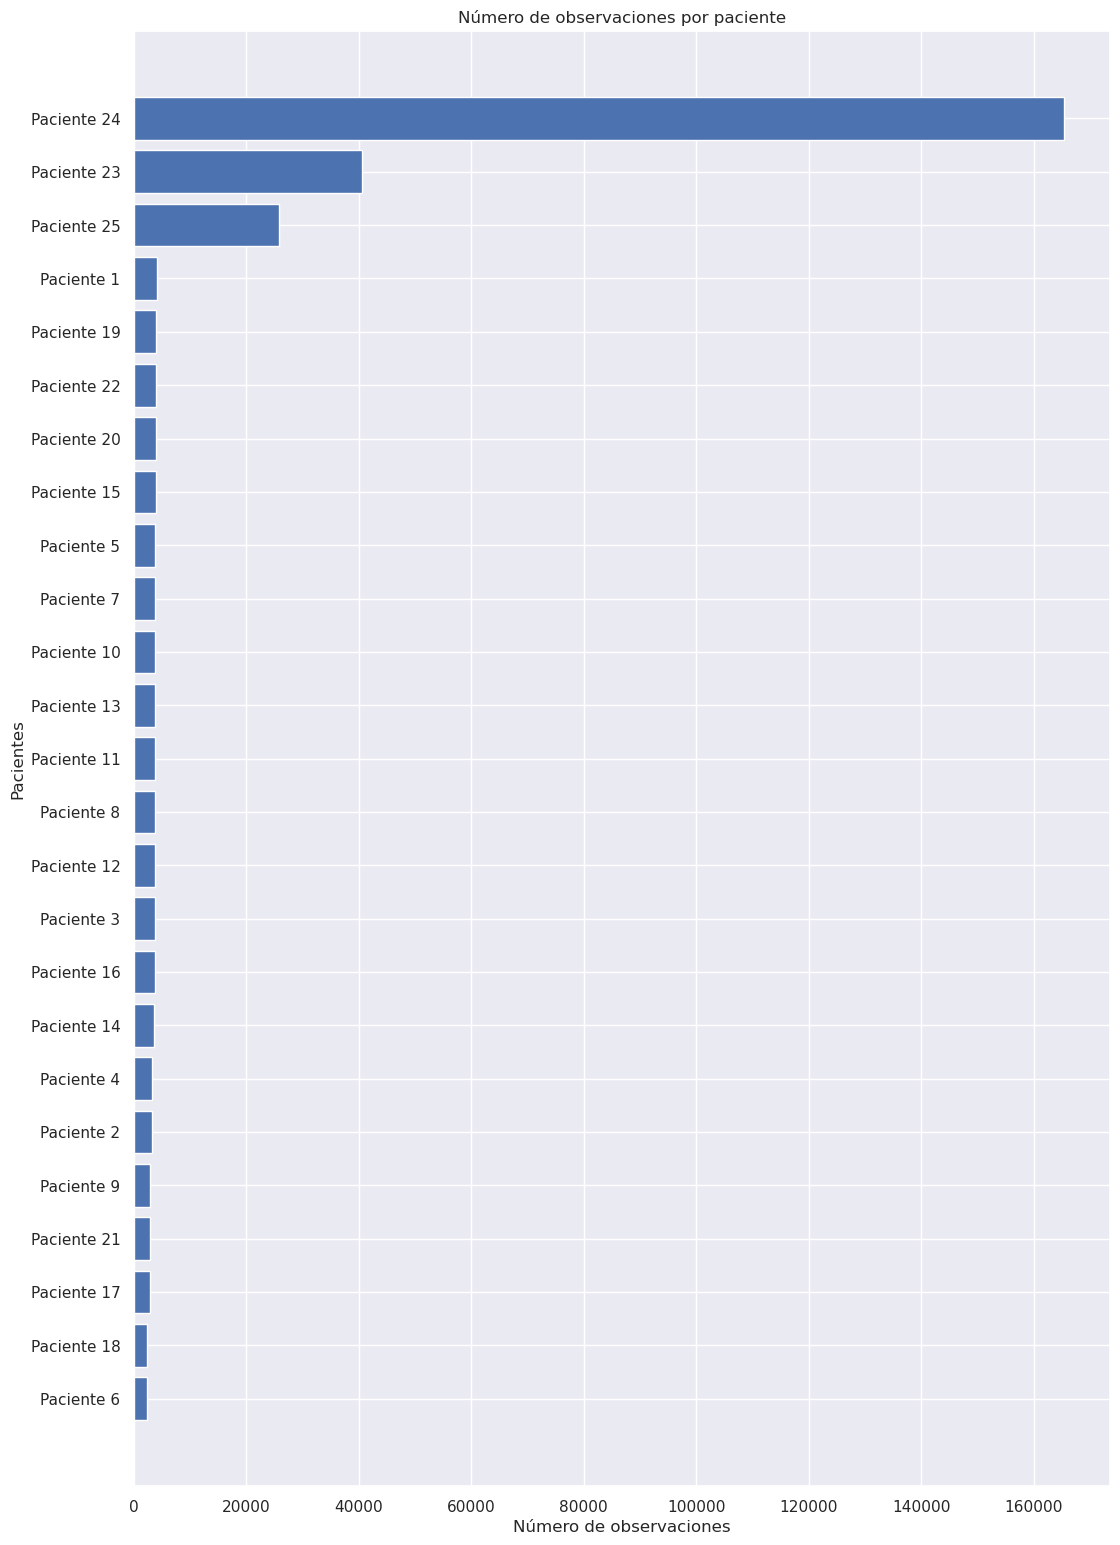

In [418]:
plt.figure(figsize=(width, width + width/2))
plt.barh([f'Paciente {key}' for key, value in patients.items()], [value for key, value in patients.items()])
plt.xlabel('Número de observaciones')
plt.ylabel('Pacientes')
plt.grid(True)
plt.title('Número de observaciones por paciente')
plt.savefig('Images/n_observaciones_por_paciente')

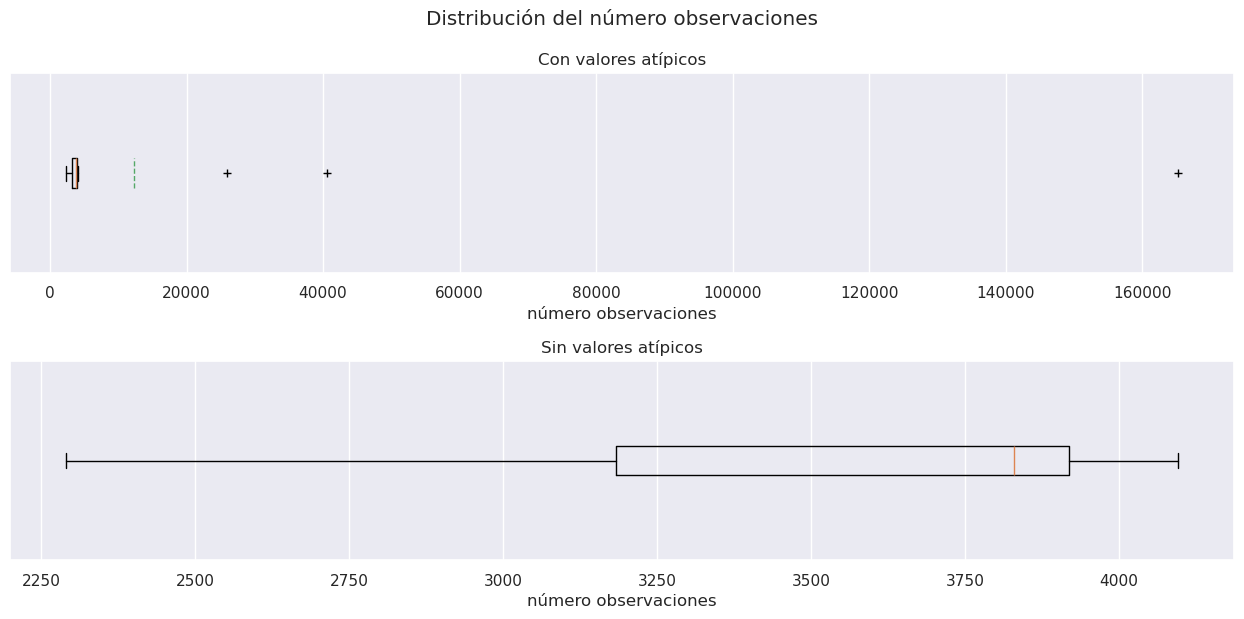

In [419]:
lengths = [len(person) for person in people]
fig, axs = plt.subplots(2, 1, figsize = (width,width/2))
axs[0].boxplot(lengths, showfliers = True, orientation = "horizontal",showbox = True, flierprops = flierprops, showmeans = True, meanline = True)
axs[0].set_xlabel("número observaciones")
axs[0].set_yticks([])
axs[0].set_title("Con valores atípicos") # Atipycal values : v > Q3 + 1.5 RIC 
axs[1].boxplot(lengths, showfliers = False, orientation = "horizontal",showbox = True, flierprops = flierprops)
axs[1].set_xlabel("número observaciones")
axs[1].set_yticks([])
axs[1].set_title("Sin valores atípicos")
plt.suptitle("Distribución del número observaciones")
plt.tight_layout()
plt.savefig("Images/distribucion_n_observaciones.png", format = "png")
plt.show()

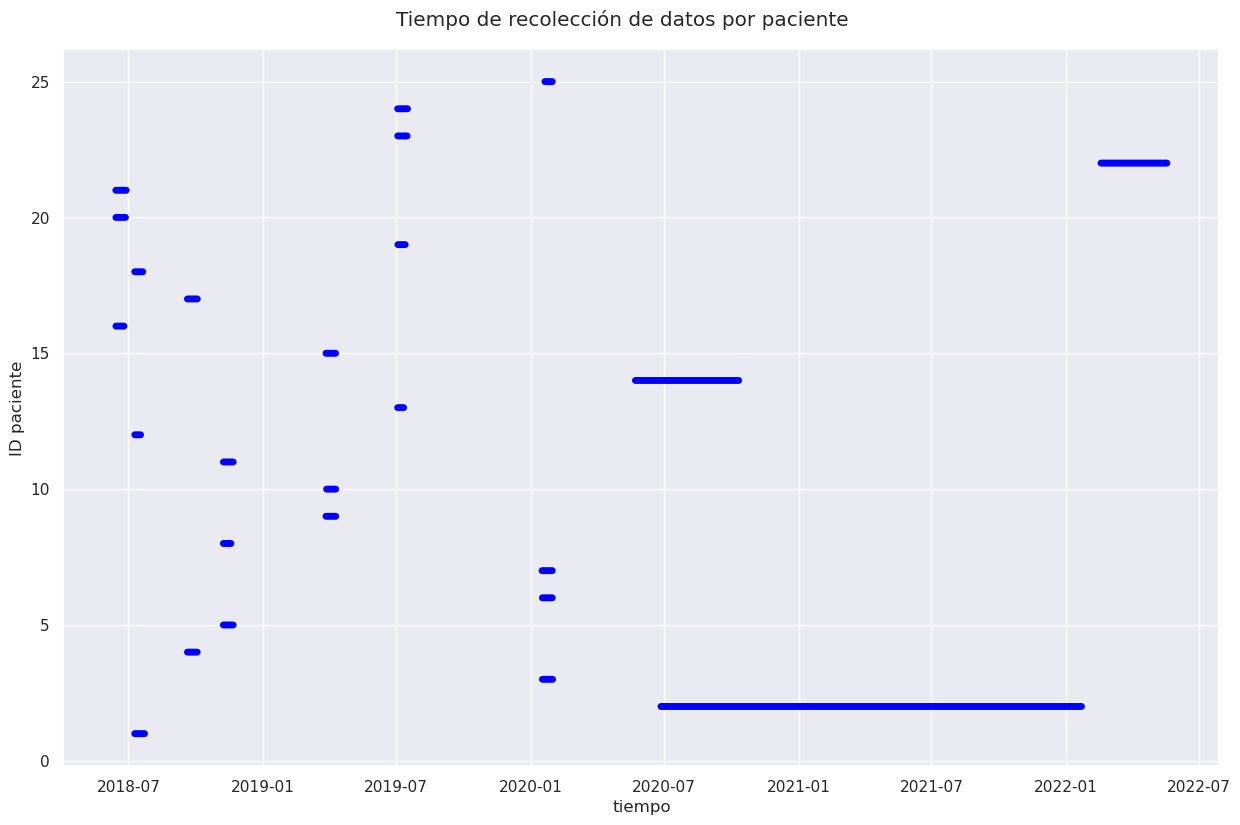

In [420]:
fig, ax = plt.subplots(figsize = (width, width/1.5))
i = 1
for person in people:
    line = [i for j in range(len(person))]
    plt.plot(person.time, line, label = f"{i}", linewidth = 5, color = "blue")
    i+= 1
ax.set_xlabel("tiempo")
ax.set_ylabel("ID paciente")
fig.suptitle("Tiempo de recolección de datos por paciente")
plt.tight_layout()
plt.savefig("Images/tiempo_recoleccion_paciente.png", format = "png")
plt.show()

#### Relations Between Variables

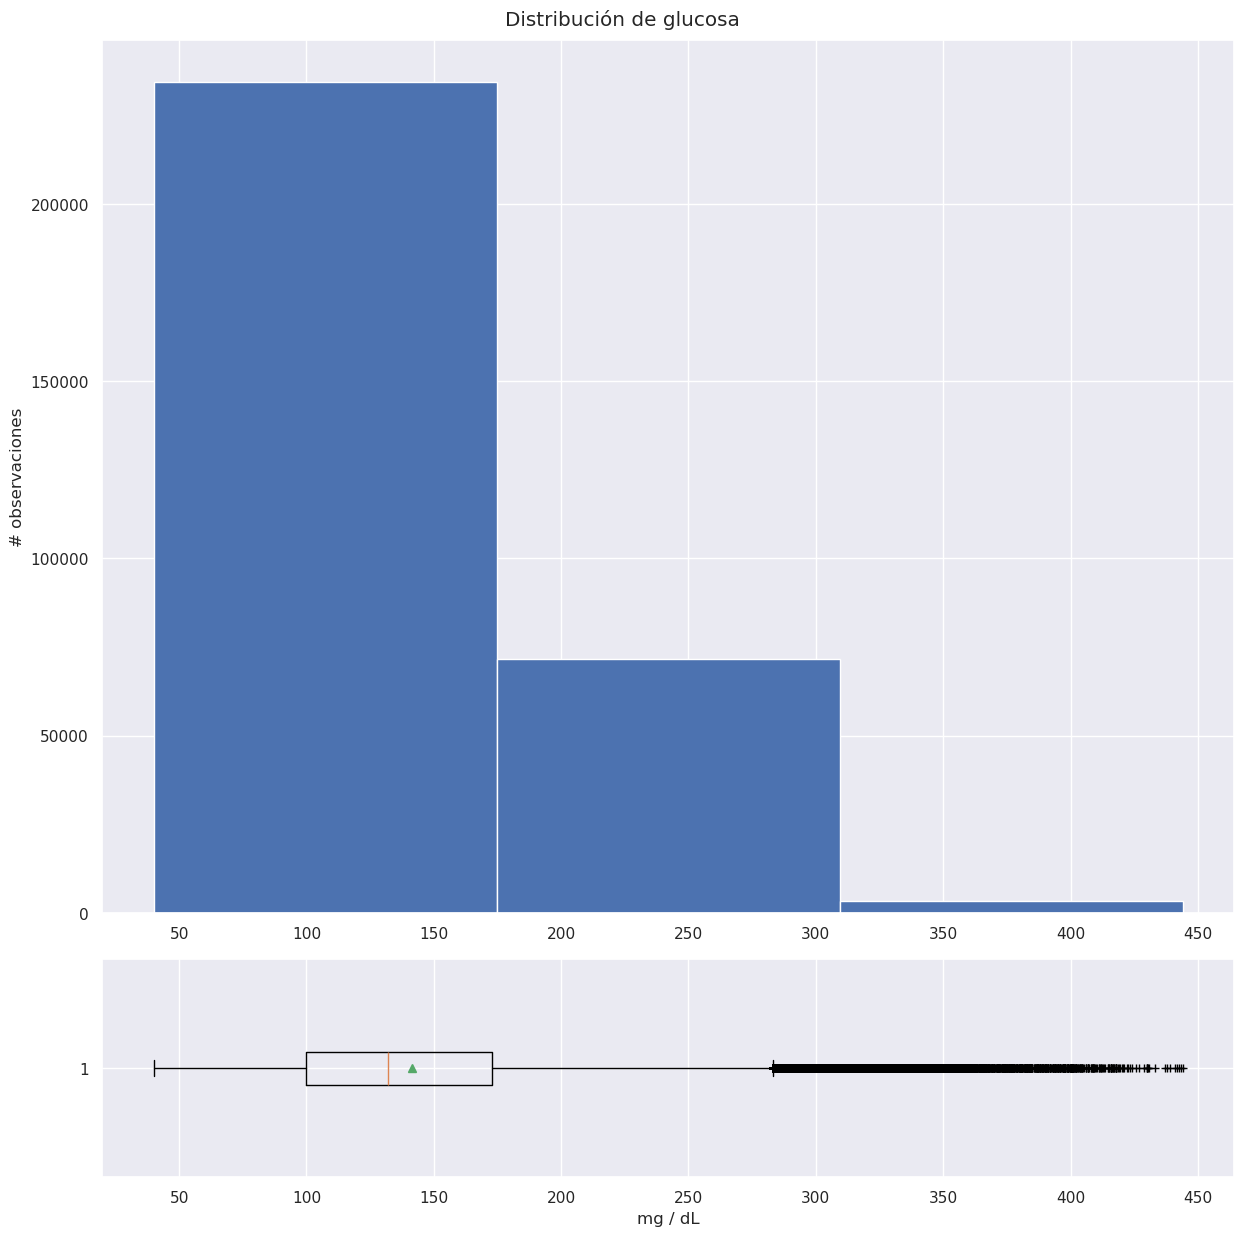

In [421]:
# Glucose distribution
glucose = df["glucose"]
fig, axs = plt.subplots(2,1, gridspec_kw = {'height_ratios': [4, 1]}, figsize = (width, width))
# bins are calculated Freedman–Diaconis rule
bins = (2 * stats.iqr(glucose) / (len(glucose)) ** (1/3))
axs[0].hist(glucose, bins = math.ceil(bins))
axs[0].set_ylabel("# observaciones")
axs[1].boxplot(glucose, orientation = "horizontal", flierprops = flierprops, showmeans = True)
axs[1].set_xlabel("mg / dL")
plt.suptitle("Distribución de glucosa")
plt.tight_layout()
plt.savefig("Images/distribucion_de_glucosa.png", format = "png")
plt.show()

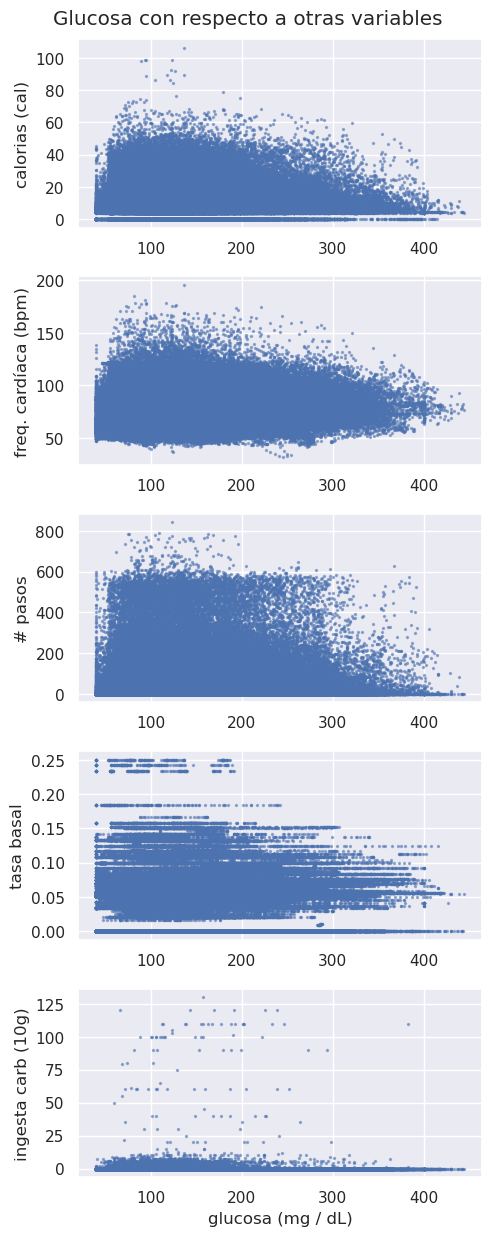

In [422]:
fig, axs = plt.subplots(5, 1, figsize = (width/2.5, width))
axs[0].scatter(glucose, df["calories"], alpha = a, s = size)
axs[0].set_ylabel("calorias (cal)")
axs[1].scatter(glucose, df["heart_rate"], alpha = a, s = size)
axs[1].set_ylabel("freq. cardíaca (bpm)")
axs[2].scatter(glucose, df["steps"], alpha = a, s = size)
axs[2].set_ylabel("# pasos")
axs[3].scatter(glucose, df["basal_rate"], alpha = a, s = size)
axs[3].set_ylabel("tasa basal")
axs[4].scatter(glucose, df["carb_input"], alpha = a, s = size)
axs[4].set_ylabel("ingesta carb (10g)")

axs[4].set_xlabel("glucosa (mg / dL)")
fig.suptitle("Glucosa con respecto a otras variables")
plt.tight_layout()
plt.savefig("Images/glucosa_respecto_a_otras_variables.png", format = "png")
plt.show()

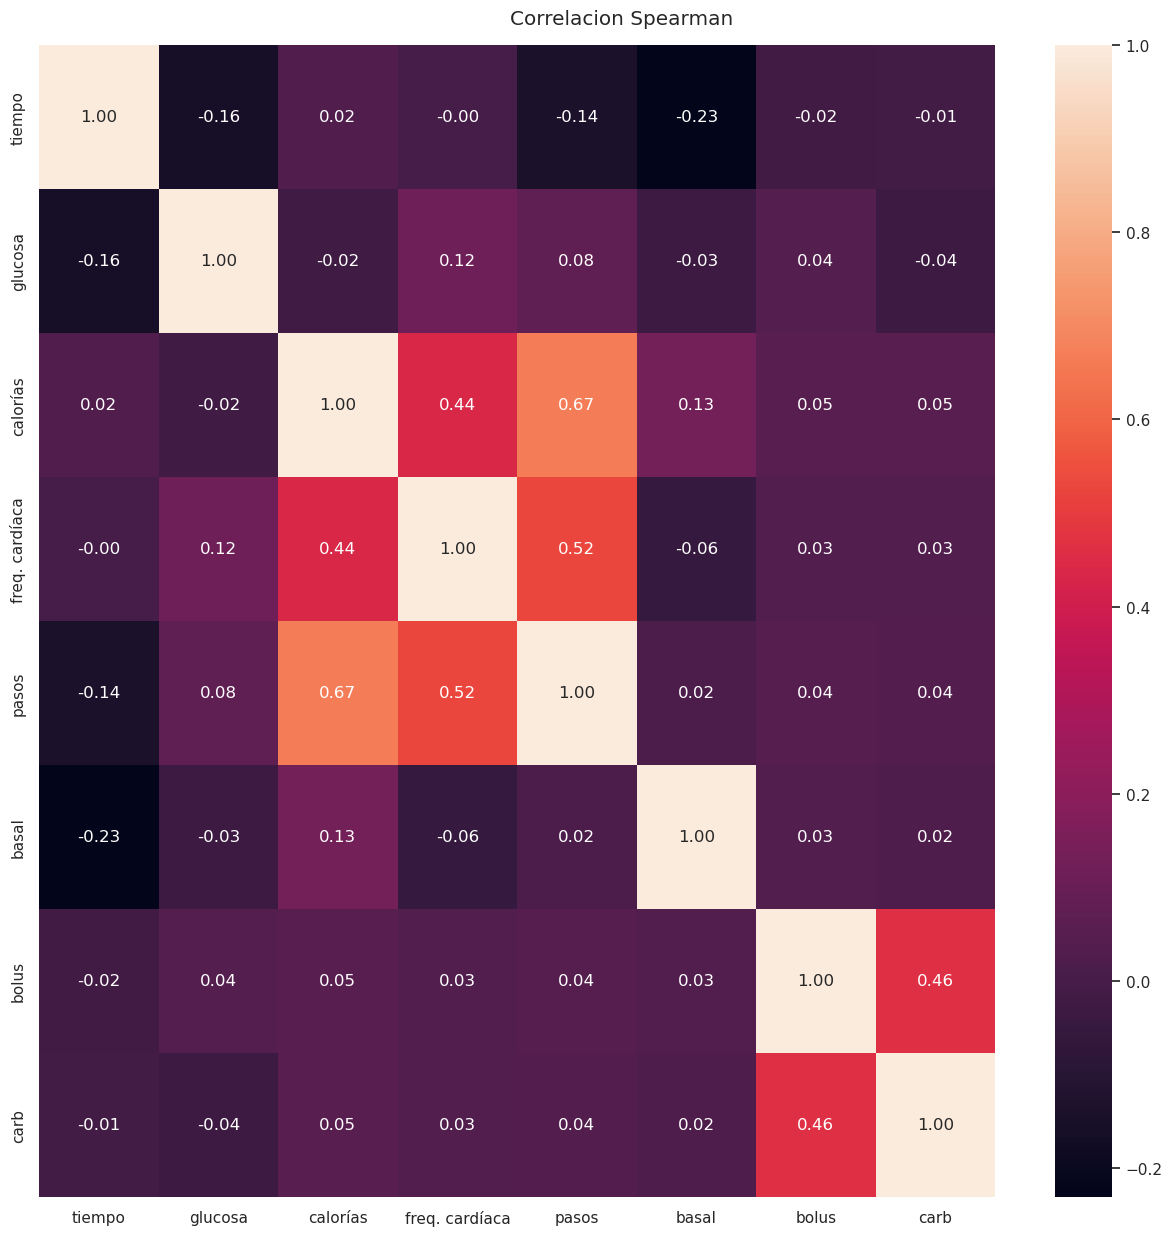

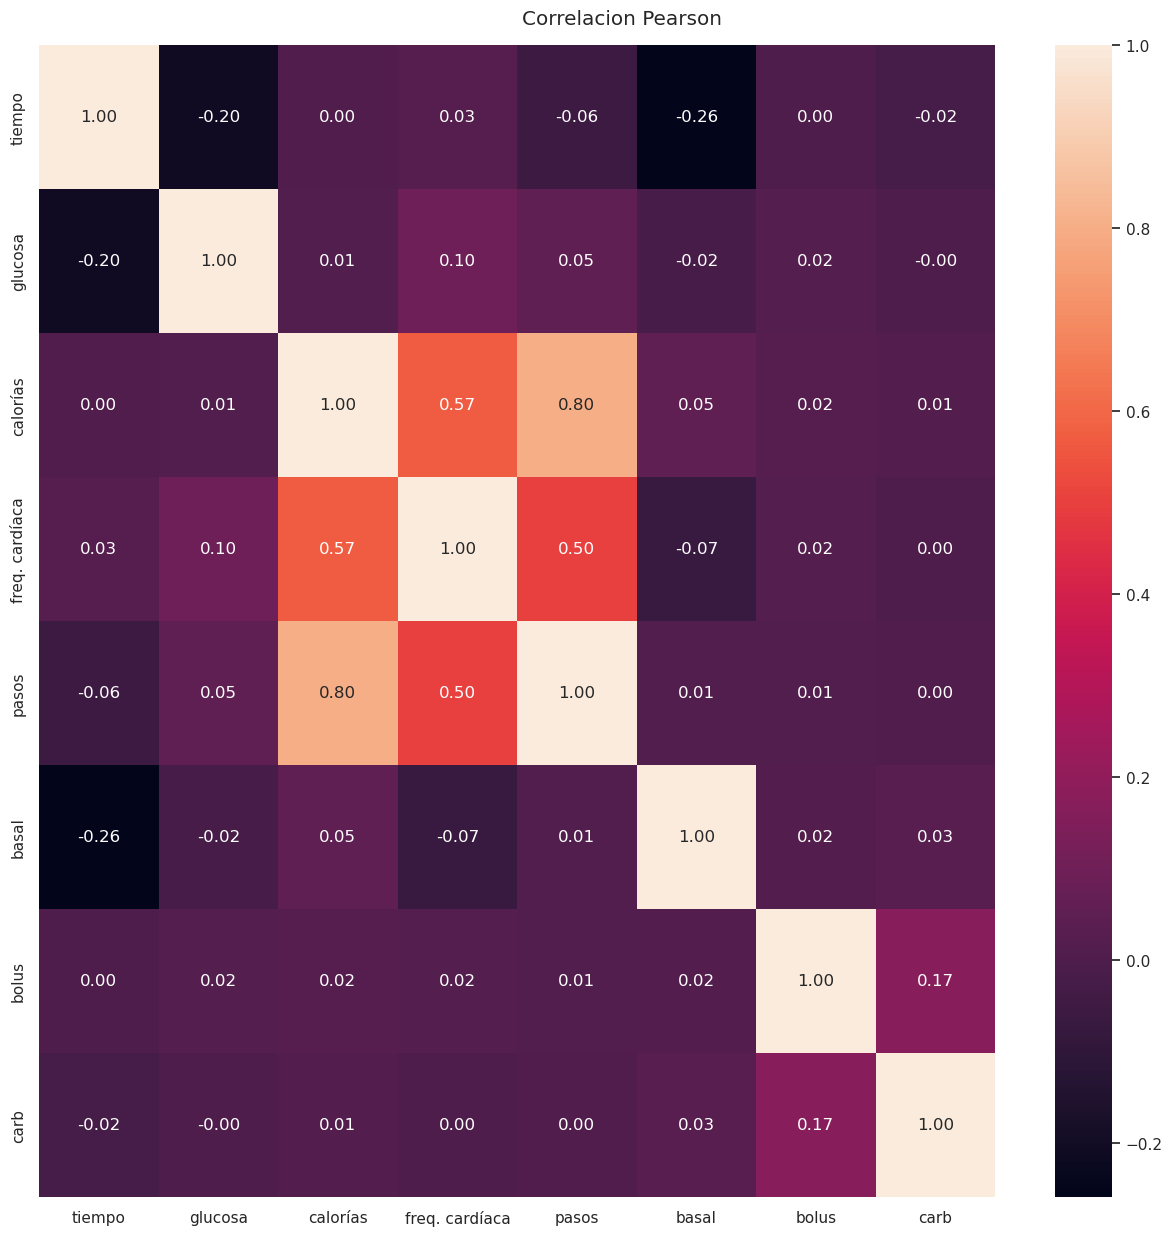

In [423]:
df_heatmap = df.copy()
df_heatmap = df_heatmap.rename(columns={
    "time" : "tiempo",
    "glucose" : "glucosa",
    "calories" : "calorías",
    "heart_rate" : "freq. cardíaca",
    "steps" : "pasos",
    "basal_rate" : "basal",
    "bolus_volume_delivered" : "bolus",
    "carb_input" : "carb",
    })
fig, ax = plt.subplots(figsize = (width,width))
sns.heatmap(df_heatmap.corr(method = "spearman"), annot = True, fmt=".2f")
plt.suptitle("Correlacion Spearman")
plt.tight_layout()
plt.savefig("Images/correlacion_spearman.png", format = "png")
plt.show()

fig, ax = plt.subplots(figsize = (width,width))
sns.heatmap(df_heatmap.corr(method = "pearson"), annot = True, fmt=".2f")
plt.suptitle("Correlacion Pearson")
plt.tight_layout()
plt.savefig("Images/correlacion_pearson.png", format = "png")
plt.show()

#### Time plots

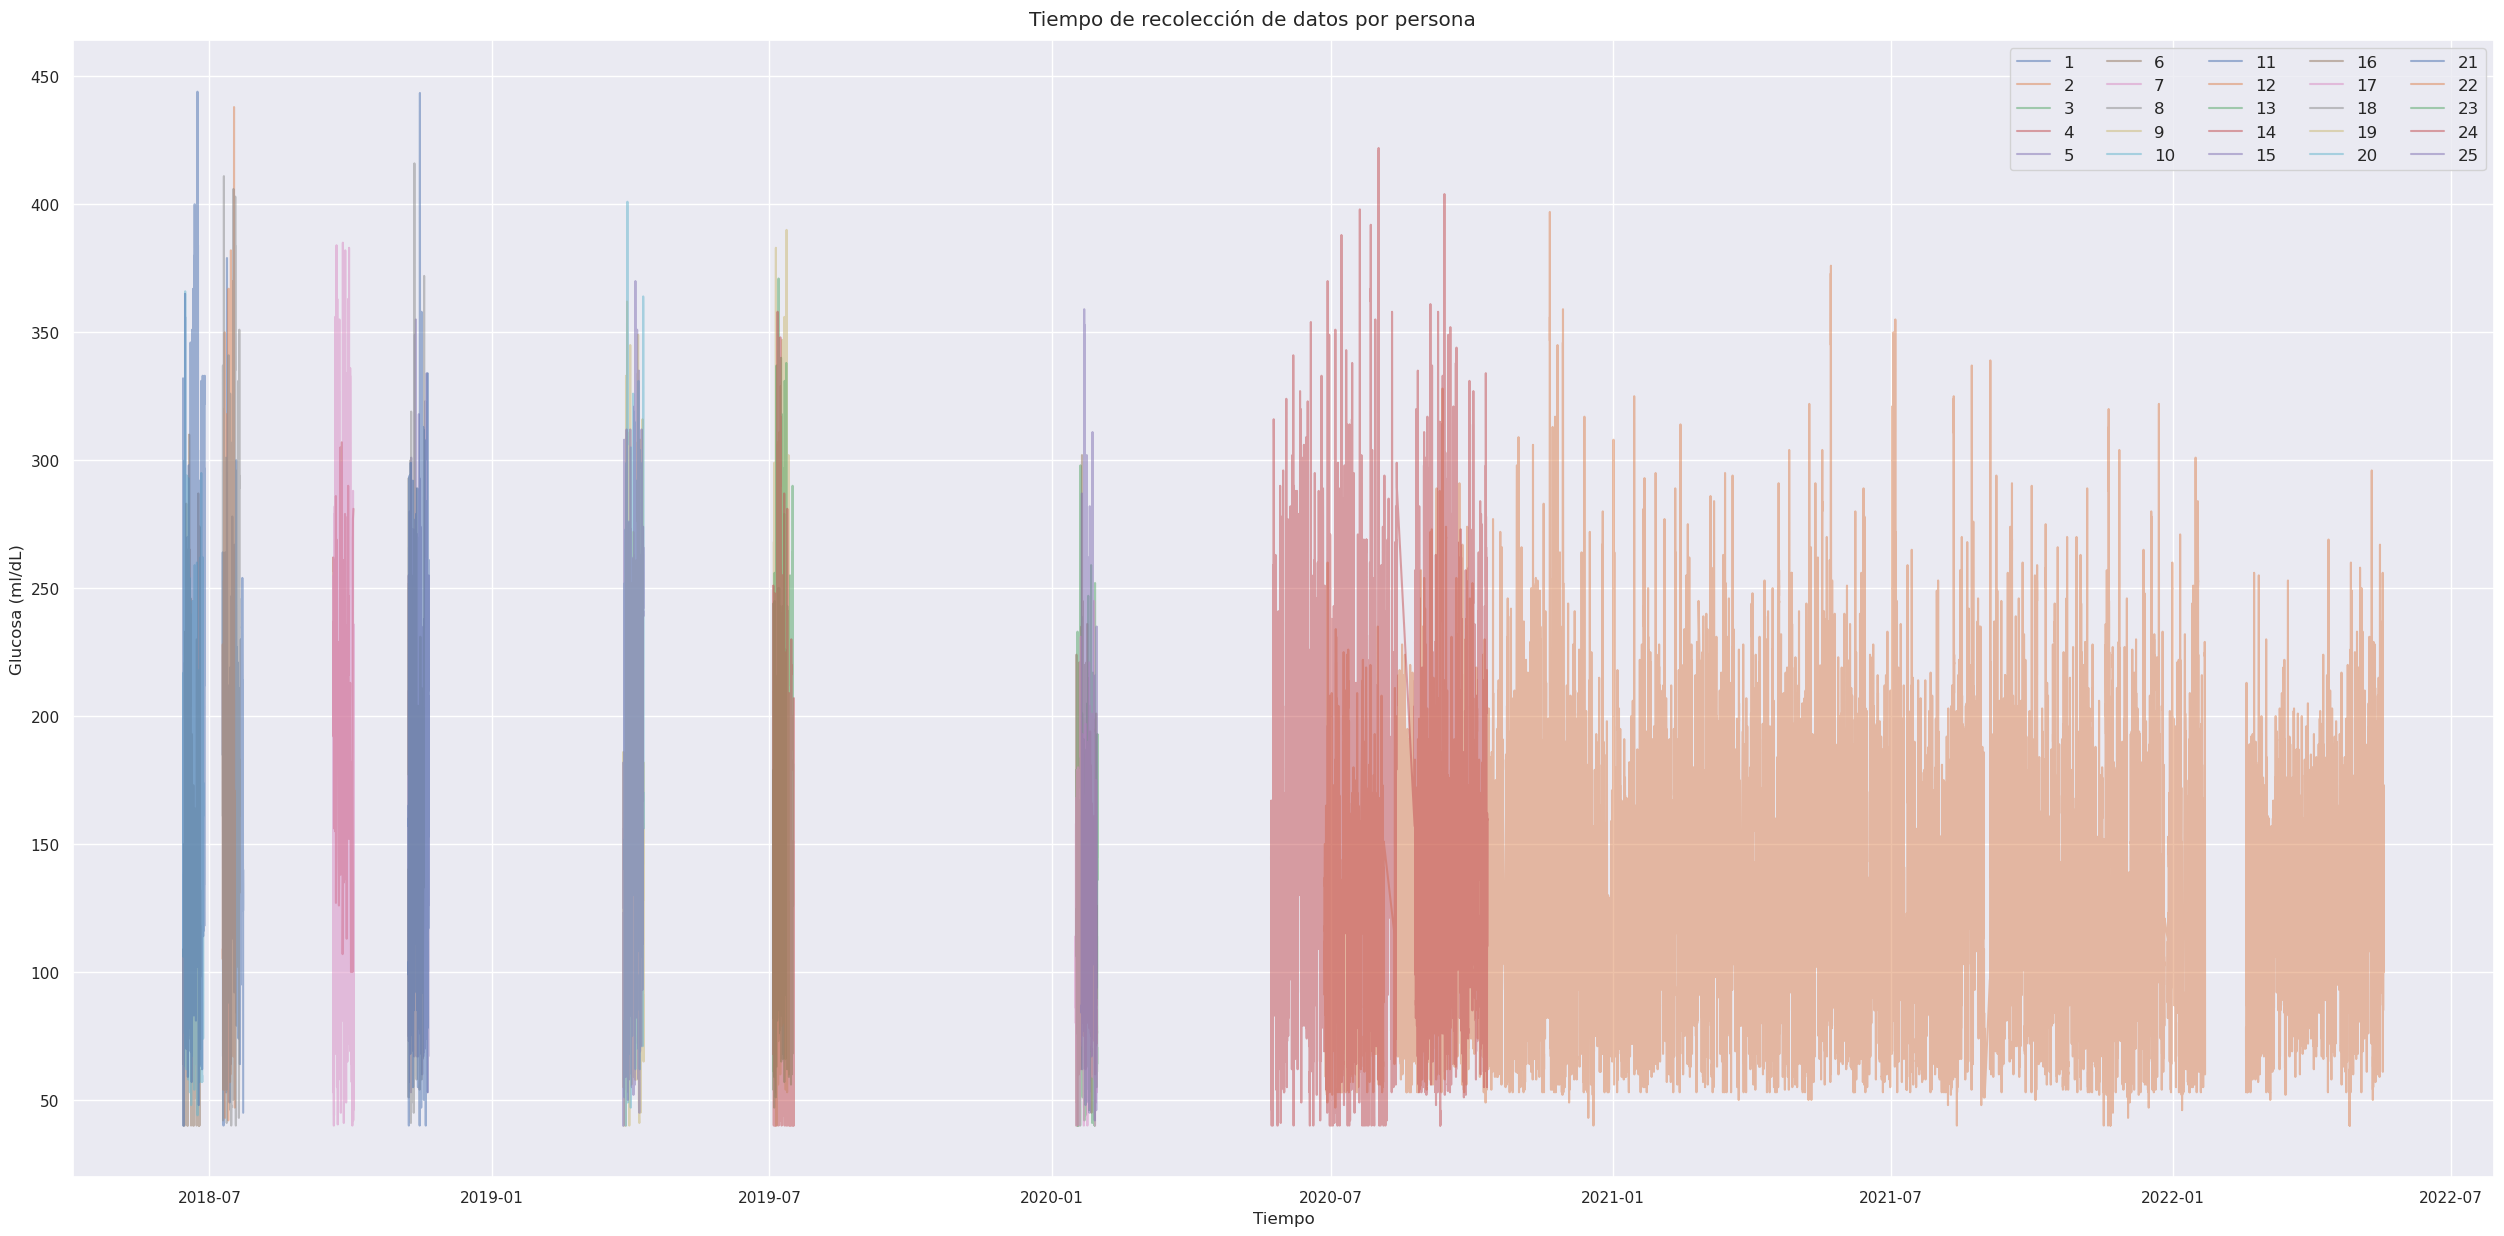

In [426]:
fig, ax = plt.subplots(figsize = (width*2, width))
i = 1
for person in people:
    plt.plot(person.time, person.glucose, alpha = a, label = f"{i}")
    i+= 1
ax.set_ylabel("Glucosa (ml/dL)")
ax.set_xlabel("Tiempo")
fig.suptitle("Tiempo de recolección de datos por persona")
plt.legend(fontsize = "medium", ncols = 5)
plt.tight_layout()
plt.savefig("Images/tiempo_recoleccion_glucosa.png", format = "png")
plt.show()